In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# A grid based model SEPP model

In (1), an explicitly grid-based self-exciting point process (SEPP) model was considered.  The paper (1) is mostly concerned with two field-trials of the SEPP or epidemic-type aftershock sequence (ETAS) type prediction models.  There is no real discussion as to why a grid based model was chosen, compared to the earlier continuous space model using kernel density estimation.

### References:

1. Mohler et al. "Randomized Controlled Field Trials of Predictive Policing". Journal of the American Statistical Association (2015) DOI:10.1080/01621459.2015.1077710
2. Lewis, Mohler, "A Nonparametric EM algorithm for Multiscale Hawkes Processes", preprint (2011) see http://math.scu.edu/~gmohler/EM_paper.pdf

# The model

The area of interest is divided into a grid; 150m squares were used in (1).  To quote from (1):

> The size of the grid cells on which μ is defined can be estimated by
maximum likelihood and in general the optimum size of the grid
cell will decrease with increasing data. However, for a fixed area
flagged for patrol, a greater number of small hotspots are more
difficult to patrol than a small number of large hotspots. The
150 × 150 m hotspots were chosen in this study to be the size
of a city block in Foothill and were then held constant across all
of the experimental regions.

The model looks _at each grid cell individually_ and uses what we might recognise as a Hawkes process (in the original form studied by Hawkes, not the more general form).  In grid cell $n$, the conditional intensity $\lambda_n(t)$ is given by

\begin{equation} \lambda_n(t) = \mu_n + \sum_{t^i_n < t} \theta \omega e^{-\omega(t-t^i_n)}
\tag{eq 1}
\end{equation}

where here:

- $\mu_n$ is the background rate in cell $n$.
- $\omega$ and $\theta$ control the "near-repeat" behaviour.  Notice that these do not depend upon $n$.
- As always, we sum over events $t^i_n$ which have occurred before the time of interest $t$, and _which have occurred in the same grid cell_.

It seems surprising that inter-cell interactions are not considered at all in this model.

# Model fitting

I do not quite understand the paper (1) here.  The following is what I think _should_ have been written.

We make initial estimates for $\mu_n$ (perhaps setting each $\mu_n$ to be the same) and $\omega, \theta$.  Then we alternate the following two steps until convergence:

### Expectation step:

Compute the upper triangular "probability matrix":

$$ p^{n}_{ji} \propto \theta\omega e^{-\omega(t_n^i - t_n^j)}, \qquad p^n_{ii} \propto \mu_n $$

where $p^{n}_{ji}$ is the probability, in cell $n$, then event $j$ triggered event $i$.  We set $p^n_{ji} = 0$ if $j > i$ and then normalise so that each column of the matrix sums to $1$ (which is why in the above formula I only give what $p^n_{ji}$ is proportional to).

### Maximisation step:

We then compute the new parameters:

$$ \omega = \frac{\sum_n \sum_{i<j} p^n_{ij}}{\sum_n \sum_{i<j} p^n_{ij}(t_n^j - t_n^i)}, \qquad
\theta = \frac{\sum_n \sum_{i<j} p^n_{ij}}{\sum_n \sum_j 1}, \qquad \mu_n = \frac{\sum_i p^n_{ii}}{T} $$
where $T$ is the time window of data under consideration.

(Note here I have given an estimate for $\mu_n$, whereas (1) seems to sum over $n$ and give an estimate for $\mu$, the total rate across the study area, but does not specify a suitable estimate for $\mu_n$.)

# Simulation

Simulating a process satisfying (eq 1) can be accomplished in the same way as simulating a more general Hawkes-type process.  However, in the simple form we have here, we can find faster simulation methods.

1. We simulate the "branching process" form.  This can be done on a cell by cell basis.
2. So firstly we simulate a homogeneous Poisson process with intensity $\mu_n$.
3. Then each point $i$ gives rise to an independent inhomogeneous Poisson process with intensity $\theta\omega e^{-\omega(t-t_i)}$ where event $i$ occurred at time $t_i$.

To simulate the process in 3 we make use of the following result.  If $\lambda^*$ is the conditional intensity of a process, then the _compensator_ is
$$ \Lambda(t) = \int_0^t \lambda^*(s) \ ds. $$
Then we have the following useful result:

> If $(t_1,\cdots,t_k)$ is a realisation of time $[0,T]$ of a point process with conditional intensity $\lambda^*$ then $\{\Lambda(t_1),\cdots,\Lambda(t_k)\}$ is unit rate Poisson process.

The converse to this statement is also true.  So, if $\Lambda$ is invertible, then we may simulate a unit rate Poisson process $\{s_1,\cdots,s_k\}$ and then $t_i  = \Lambda^{-1}(s_i)$ will be a process with conditional intensity $\lambda^*$.

In our case, $\lambda^*(t) = \theta\omega e^{-\omega t}$ (translating so that the "trigger" event occurs at $t=0$) and so
$$ \Lambda(t) = \theta \int_0^t \omega e^{-\omega s} \ ds = \theta \Big[ -e^{-\omega s} \Big]_0^t
= \theta\big( 1- e^{-\omega t} \big). $$
This has inverse $\Lambda^{-1}(s) = \omega^{-1} \log(\theta / (\theta - s) )$ defined for $0\leq s < \theta$. So

- Simulate a unit rate Poisson process $\{s_1,\cdots,s_k\}$ on $[0,\theta)$ and then set $t_i = \Lambda^{-1}(s_i)$ to get the "after-shock" events.
- This allows us to think about the parameters $\theta$ and $\omega$.  $\theta$ controls the rate of the process-- we expect an average of $\theta$ events.  $\omega$ controls the scale of the resulting process.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import open_cp

## Simulate some test data

We lay down a grid, set a random background rate in each cell, simulate the process, and then add some noise to generate x,y coordinates in each grid cell.  This is obviously a bit artifical, as in real data, it is likely that the background rate in a cell will be related to the background rate in neighbouring cells.

In [3]:
import open_cp.sources.sepp as source_sepp

rates = np.random.random(size=(10,10))
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
points = simulation.sample_to_randomised_grid(0, 365, grid_size=50)
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1),
    time_unit)

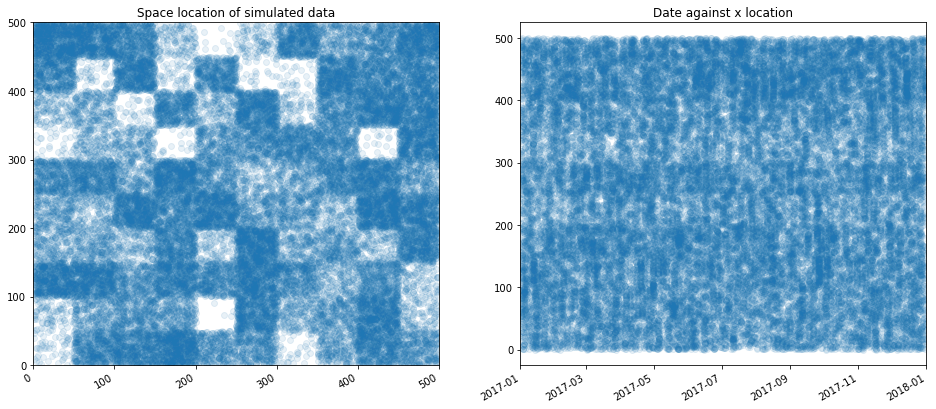

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.1)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,500], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.1)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

# Train the model

Remember that we rescaled time.
- We sample initially with an implied unit of "days", and then convert to minutes; one day = 1440 minutes
- The aftershock rate was initially 10, so a mean of 0.1 days which becomes 144 minutes
- So the rate we look for is 1/144 = 0.00694...

In [5]:
import open_cp.seppexp as sepp

In [6]:
region = open_cp.RectangularRegion(xmin=0, xmax=500, ymin=0, ymax=500)
trainer = sepp.SEPPTrainer(region, grid_size=50)
trainer.data = timed_points
predictor = trainer.train(iterations=50)
print("Predicted omega={}, theta={}".format(predictor.omega, predictor.theta))

Predicted omega=0.006955745919879276, theta=0.5006558130258035


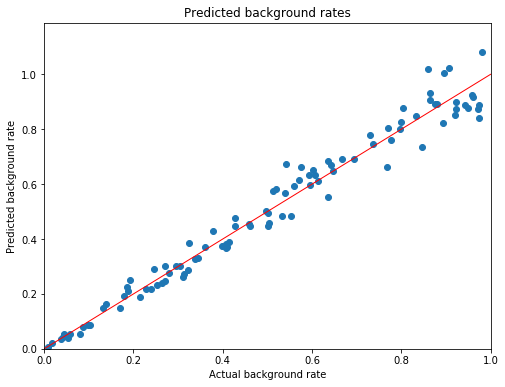

In [7]:
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.plot([0,1], [0,1], linewidth=1, color="r")
ax.scatter(rates.ravel(), predictor.mu.ravel()*1440)
ax.set(xlim=[0,1], ylim=[0,np.max(predictor.mu)*1440*1.1])
ax.set(xlabel="Actual background rate", ylabel="Predicted background rate")
ax.set_title("Predicted background rates")
None

# Make predictions

Once trained, we have an estimate of the background rate in each grid cell, and the global parameters $\theta, \omega$ describing the triggering / aftershock behaviour.  These can then be applied to any data fitting the same grid pattern (though of course the data should be compatible!)

In [8]:
predictor.data = timed_points
dates = [datetime.datetime(2018,1,1), datetime.datetime(2018,1,2)]
predictions = [predictor.predict(date) for date in dates]
background_prediction = predictor.background_prediction()

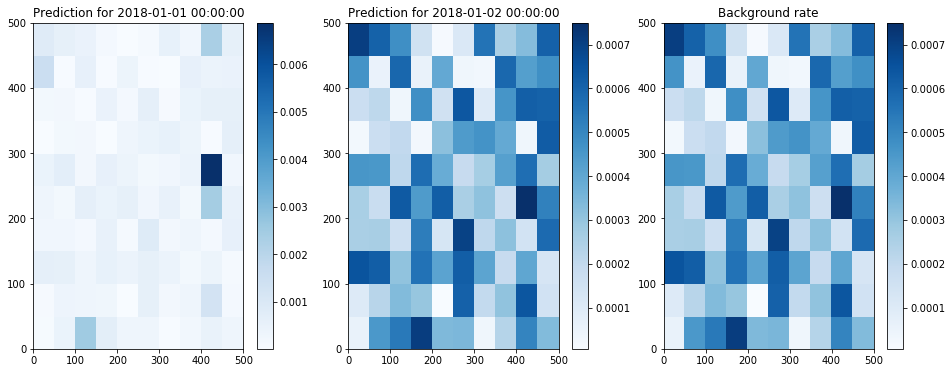

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(16,6))
for a in ax:
    a.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])

for pred, date, a in zip(predictions, dates, ax):
    m = a.pcolormesh(*pred.mesh_data(), pred.intensity_matrix, cmap="Blues")
    a.set_title("Prediction for {}".format(date))
    fig.colorbar(m, ax=a)

m2 = ax[2].pcolormesh(*background_prediction.mesh_data(), background_prediction.intensity_matrix, cmap="Blues")
ax[2].set_title("Background rate")
fig.colorbar(m2, ax=ax[2])
None

As with the other SEPP model, we see that "aftershocks" dominate the prediction, but as we predict further into the future, we converge on the background rate.

A more realistic "prediction" method would be to simulate future events using the model, and then compute the intensity based on this simulation, perhaps finally taking an average over many simulations.